
# Job Search I: The McCall Search Model

> "Questioning a McCall worker is like having a conversation with an out-of-work friend:
'Maybe you are setting your sights too high', or 'Why did you quit your old job before you
had a new one lined up?' This is real social science: an attempt to model, to understand,
human behavior by visualizing the situation people find themselves in, the options they face
and the pros and cons as they themselves see them." -- Robert E. Lucas, Jr.

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:

!pip install quantecon 

## Overview

The McCall search model  helped transform economists' way of thinking about labor markets.

To clarify  notions such as "involuntary" unemployment, McCall modeled the decision problem of an unemployed worker  in terms of factors including

* current and likely future wages
* impatience
* unemployment compensation

To solve the decision problem McCall used dynamic programming.

Here we set up McCall's model and use dynamic programming to analyze it.

As we'll see, McCall's model is not only interesting in its own right but also an excellent vehicle for learning dynamic programming.

Let's start with some imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import jax
import jax.numpy as jnp
from typing import NamedTuple
from functools import partial
import quantecon as qe
from quantecon.distributions import BetaBinomial

## The McCall Model

An unemployed agent receives in each period a job offer at wage $w_t$.

In this lecture, we adopt the following simple environment:

* The offer sequence $\{w_t\}_{t \geq 0}$ is IID, with $q(w)$ being the probability of observing wage $w$ in finite set $\mathbb{W}$.
* The agent observes $w_t$ at the start of $t$.
* The agent knows that $\{w_t\}$ is IID with common distribution $q$ and can use this when computing expectations.

(In later lectures, we will relax these assumptions.)

At time $t$, our agent has two choices:

1. Accept the offer and work permanently at constant wage $w_t$.
1. Reject the offer, receive unemployment compensation $c$, and reconsider next period.

The agent is infinitely lived and aims to maximize the expected discounted
sum of earnings

$$
{\mathbb E} \sum_{t=0}^\infty \beta^t y_t
$$

The constant $\beta$ lies in $(0, 1)$ and is called a **discount factor**.

The smaller is $\beta$, the more the agent discounts future earnings relative to current earnings.

The variable  $y_t$ is income, equal to

* his/her wage $w_t$ when employed
* unemployment compensation $c$ when unemployed

### A Trade-Off

The worker faces a trade-off:

* Waiting too long for a good offer is costly, since the future is discounted.
* Accepting too early is costly, since better offers might arrive in the future.

To decide the optimal wait time in the face of this trade-off, we use [dynamic programming](https://dp.quantecon.org/).

Dynamic programming can be thought of as a two-step procedure that

1. first assigns values to "states" and
1. then deduces optimal actions given those values

We'll go through these steps in turn.

### The Value Function

In order to optimally trade-off current and future rewards, we need to think about two things:

1. the current payoffs we get from different choices
1. the different states that those choices will lead to in next period

To weigh these two aspects of the decision problem, we need to assign *values*
to states.

To this end, let $v^*(w)$ be the total lifetime value accruing to an
unemployed worker who enters the current period unemployed when the wage is
$w \in \mathbb{W}$.

(In particular, the agent has wage offer $w$ in hand and can accept or reject it.)

More precisely, $v^*(w)$ denotes the total sum of expected discounted earnings
when an agent always behaves in an optimal way. points in time.

Of course $v^*(w)$ is not trivial to calculate because we don't yet know
what decisions are optimal and what aren't!

If we don't know what opimal choices are, it feels imposible to calculate
$v^*(w)$.

But let's put this aside for now and think of $v^*$ as a function that assigns
to each possible wage $w$ the maximal lifetime value $v^*(w)$ that can be
obtained with that offer in hand.

A crucial observation is that this function $v^*$ must satisfy 

$$
v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta
        \sum_{w' \in \mathbb{W}} v^*(w') q (w')
    \right\}
$$

for every possible $w$  in $\mathbb{W}$.

This is a version of the **Bellman equation**, which is
ubiquitous in economic dynamics and other fields involving planning over time.

The intuition behind it is as follows:

* the first term inside the max operation is the lifetime payoff from accepting current offer, since
    such a worker works forever at $w$ and values this income stream as

$$
    \frac{w}{1 - \beta} = w + \beta w + \beta^2 w + \cdots
$$

* the second term inside the max operation is the continuation value, which is
  the lifetime payoff from rejecting the current offer and then behaving
  optimally in all subsequent periods

If we optimize and pick the best of these two options, we obtain maximal
lifetime value from today, given current offer $w$.

But this is precisely $v^*(w)$, which is the left-hand side of the Bellman equation.

Putting this all together, we see that the Bellman equation is valid for all $w$.

### The Optimal Policy

We still don't know how to compute $v^*$  (although the Bellman equation gives us hints
we'll return to below).

But suppose for now that we do know $v^*$.

Once we have this function in hand we can easily make optimal choices (i.e., make the
right choice between accept and reject given any $w$).

All we have to do is select the maximal choice on the right-hand side of the Bellman equation.

In other words, we make the best choice between stopping and continuing, given
the information provided to us by $v^*$.

The optimal action is best thought of as a **policy**, which is, in general, a map from
states to actions.

Given any $w$, we can read off the corresponding best choice (accept or
reject) by picking the max on the right-hand side of the Bellman equation.

Thus, we have a map from $\mathbb W$ to $\{0, 1\}$, with 1 meaning accept and 0 meaning reject.

We can write the policy as follows

$$
\sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w' \in \mathbb W}
        v^*(w') q (w')
    \right\}
$$

Here $\mathbf{1}\{ P \} = 1$ if statement $P$ is true and equals 0 otherwise.

We can also write this as

$$
    \sigma(w) := \mathbf{1} \{ w \geq \bar w \}
$$

where

$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') q (w') \right\}
$$

Here $\bar w$ (called the **reservation wage**) is a constant depending on
$\beta, c$ and the wage distribution.

The agent should accept if and only if the current wage offer exceeds the reservation wage.

In view of the reservation wage equation, we can compute this reservation wage if we can compute the value function.

## Computing the Optimal Policy: Take 1

To put the above ideas into action, we need to compute the value function at each $w \in \mathbb W$.

To simplify notation, let's set

$$
\mathbb W := \{w_1, \ldots, w_n  \}
    \quad \text{and} \quad
    v^*(i) := v^*(w_i)
$$

The value function is then represented by the vector $v^* = (v^*(i))_{i=1}^n$.

In view of the Bellman equation, this vector satisfies the nonlinear system of equations

$$
v^*(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{j=1}^n 
            v^*(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
$$



### The Algorithm

To compute this vector, we use successive approximations:

Step 1: pick an arbitrary initial guess $v \in \mathbb R^n$.

Step 2: compute a new vector $v' \in \mathbb R^n$ via

$$
v'(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{j=1}^n
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
$$

Step 3: calculate a measure of a discrepancy between $v$ and $v'$, such as $\max_i |v(i)- v'(i)|$.

Step 4: if the deviation is larger than some fixed tolerance, set $v = v'$ and go to step 2, else continue.

Step 5: return $v$.

For a small tolerance, the returned function $v$ is a close approximation to the value function $v^*$.

The theory below elaborates on this point.

### Fixed Point Theory

What's the mathematics behind these ideas?

First, one defines a mapping $T$ from $\mathbb R^n$ to itself via

$$
(Tv)(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{j=1}^n
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
$$

(A new vector $Tv$ is obtained from given vector $v$ by evaluating
the r.h.s. at each $i$.)

The element $v_k$ in the sequence $\{v_k\}$ of successive approximations corresponds to $T^k v$.

* This is $T$ applied $k$ times, starting at the initial guess $v$

One can show that the conditions of the [Banach fixed point theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem) are
satisfied by $T$ on $\mathbb R^n$.

One implication is that $T$ has a unique fixed point in $\mathbb R^n$.

* That is, a unique vector $\bar v$ such that $T \bar v = \bar v$.

Moreover, it's immediate from the definition of $T$ that this fixed point is $v^*$.

A second implication of the  Banach contraction mapping theorem is that
$\{ T^k v \}$ converges to the fixed point $v^*$ regardless of $v$.

### Implementation

Our default for $q$, the wage offer distribution, will be [Beta-binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution).

In [3]:
n, a, b = 50, 200, 100                        # default parameters
q_default = jnp.array(BetaBinomial(n, a, b).pdf())

Our default set of values for wages will be

In [4]:
w_min, w_max = 10, 60
w_default = jnp.linspace(w_min, w_max, n+1)

Here's a plot of the probabilities of different wage outcomes:

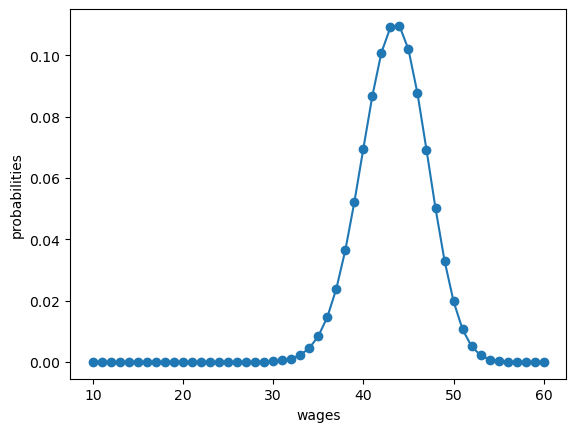

In [5]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

We will use [JAX](https://python-programming.quantecon.org/jax_intro.html) to write our code.

We'll use `NamedTuple` for our model class to maintain immutability, which works well with JAX's functional programming paradigm.

Here's a class that stores the model parameters with default values.

In [6]:
class McCallModel(NamedTuple):
    c: float = 25               # unemployment compensation
    β: float = 0.99             # discount factor  
    w: jnp.ndarray = w_default  # array of wage values, w[i] = wage at state i
    q: jnp.ndarray = q_default  # array of probabilities

We implement the Bellman operator $T$ from the Bellman equation, which we can write in
terms of array operations as

$$
Tv
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta \sum_{j=1}^n v(j) q (j)
    \right\}
\quad
$$

(The first term inside the max is an array and the second is just a number -- here
we mean that the max comparison against this number is done element-by-element for all elements in the array.)

We can code $T$ up as follows.

In [7]:
def T(model: McCallModel, v: jnp.ndarray):
    c, β, w, q = model
    accept = w / (1 - β)
    reject = c + β * v @ q
    return jnp.maximum(accept, reject)

Based on these defaults, let's try plotting the first few approximate value functions
in the sequence $\{ T^k v \}$.

We will start from guess $v$ given by $v(i) = w(i) / (1 - β)$, which is the value of accepting at every given wage.

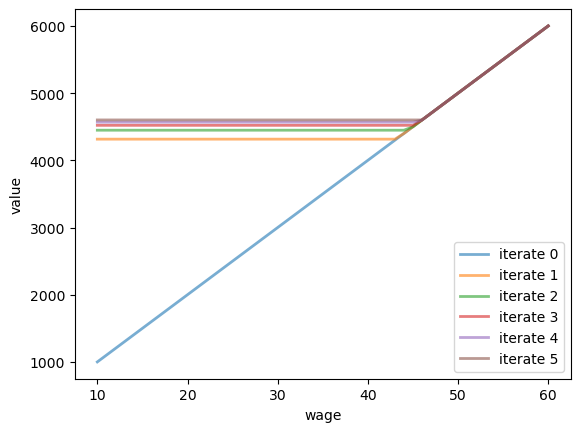

In [8]:
model = McCallModel()
c, β, w, q = model
v = w / (1 - β)   # Initial condition
fig, ax = plt.subplots()

num_plots = 6
for i in range(num_plots):
    ax.plot(w, v, '-', alpha=0.6, lw=2, label=f"iterate {i}")
    v = T(model, v)

ax.legend(loc='lower right')
ax.set_xlabel('wage')
ax.set_ylabel('value')
plt.show()

You can see that convergence is occurring: successive iterates are getting closer together.

Here's a more serious iteration effort to compute the limit, which continues
until measured deviation between successive iterates is below `tol`.

Once we obtain a good approximation to the limit, we will use it to calculate
the reservation wage.

In [9]:
def compute_reservation_wage(
        model: McCallModel,   # instance containing default parameters
        v_init: jnp.ndarray,  # initial condition for iteration
        tol: float=1e-6,      # error tolerance
        max_iter: int=500,    # maximum number of iterations for loop
    ):
    "Computes the reservation wage in the McCall job search model."
    c, β, w, q = model
    i = 0
    error = tol + 1 
    v = v_init
    
    while i < max_iter and error > tol:
        v_next = T(model, v)
        error = jnp.max(jnp.abs(v_next - v))
        v = v_next
        i += 1
    
    res_wage = (1 - β) * (c + β * v @ q)
    return v, res_wage

The cell computes the reservation wage at the default parameters

In [10]:
model = McCallModel()
c, β, w, q = model
v_init = w / (1 - β)  # initial guess
v, res_wage = compute_reservation_wage(model, v_init)
print(res_wage)

47.31644


### Comparative Statics

Now that we know how to compute the reservation wage, let's see how it varies with
parameters.

Here we compare the reservation wage at two values of $\beta$.

The reservation wages will be plotted alongside the wage offer distribution, so
that we can get a sense of what fraction of offers will be accepted.

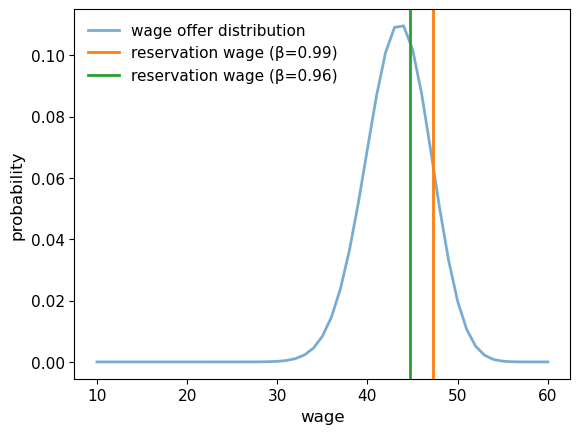

In [11]:
fig, ax = plt.subplots()

# Get the default color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot the wage offer distribution
ax.plot(w, q, '-', alpha=0.6, lw=2,
        label='wage offer distribution', 
        color=colors[0])

# Compute reservation wage with default beta
model_default = McCallModel()
v_init = model_default.w / (1 - model_default.β)
v_default, res_wage_default = compute_reservation_wage(
    model_default, v_init
)

# Compute reservation wage with lower beta
β_new = 0.96
model_low_beta = McCallModel(β=β_new)
v_init_low = model_low_beta.w / (1 - model_low_beta.β)
v_low, res_wage_low = compute_reservation_wage(
    model_low_beta, v_init_low
)

# Plot vertical lines for reservation wages
ax.axvline(x=res_wage_default, color=colors[1], lw=2,
           label=f'reservation wage (β={model_default.β})')
ax.axvline(x=res_wage_low, color=colors[2], lw=2,
           label=f'reservation wage (β={β_new})')

ax.set_xlabel('wage', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(loc='upper left', frameon=False, fontsize=11)
plt.show()

We see that the reservation wage is higher when $\beta$ is higher.

This is not surprising, since higher $\beta$ is associated with more patience.

Now let's look more systematically at what happens when we change $\beta$ and $c$.

As a first step, given that we'll use it many times, let's create a more
efficient, jit-complied version of the function that computes the reservation
wage:

In [12]:
@jax.jit
def compute_res_wage_jitted(
        model: McCallModel,   # instance containing default parameters
        v_init: jnp.ndarray,  # initial condition for iteration
        tol: float=1e-6,      # error tolerance
        max_iter: int=500,    # maximum number of iterations for loop
    ):
    c, β, w, q = model
    i = 0
    error = tol + 1 
    initial_state = v_init, i, error
    
    def cond(loop_state):
        v, i, error = loop_state
        return jnp.logical_and(i < max_iter, error > tol)

    def update(loop_state):
        v, i, error = loop_state
        v_next = T(model, v)
        error = jnp.max(jnp.abs(v_next - v))
        i += 1
        new_loop_state = v_next, i, error
        return new_loop_state
    
    final_state = jax.lax.while_loop(cond, update, initial_state)
    v, i, error = final_state

    res_wage = (1 - β) * (c + β * v @ q)
    return v, res_wage

Now we compute the reservation wage at each $c, \beta$ pair.

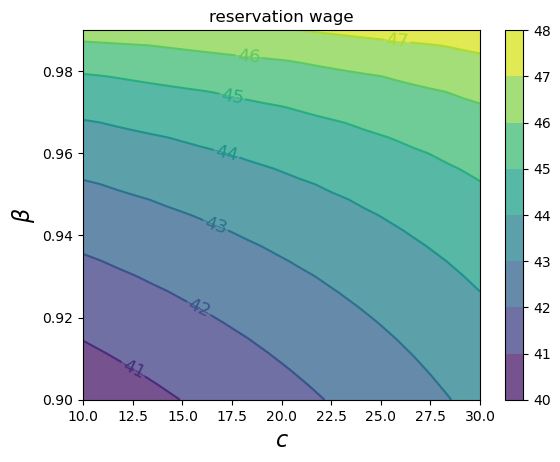

In [13]:
grid_size = 25
c_vals = jnp.linspace(10.0, 30.0, grid_size)
β_vals = jnp.linspace(0.9, 0.99, grid_size)

res_wage_matrix = np.empty((grid_size, grid_size))
model = McCallModel()
v_init = model.w / (1 - model.β)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        model = McCallModel(c=c, β=β)
        v, res_wage = compute_res_wage_jitted(model, v_init)
        v_init = v
        res_wage_matrix[i, j] = res_wage

fig, ax = plt.subplots()
cs1 = ax.contourf(c_vals, β_vals, res_wage_matrix.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, res_wage_matrix.T)
plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)
ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
ax.ticklabel_format(useOffset=False)
plt.show()

As expected, the reservation wage increases with both patience and unemployment compensation.

## Computing an Optimal Policy: Take 2

The approach to dynamic programming just described is standard and broadly applicable.

But for our McCall search model there's also an easier way that circumvents the
need to compute the value function.

Let $h$ denote the continuation value:

$$
h = c + \beta \sum_{w'} v^*(w') q (w')
$$

The Bellman equation can now be written as

$$
    v^*(w')
    = \max \left\{ \frac{w'}{1 - \beta}, \, h \right\}
$$

Substituting this last equation into equation (j1) gives

$$
h = c + \beta
        \sum_{w' \in \mathbb W}
        \max \left\{
            \frac{w'}{1 - \beta}, h
        \right\}  q (w')
$$

This is a nonlinear equation that we can solve for $h$.

As before, we will use successive approximations:

Step 1: pick an initial guess $h$.

Step 2: compute the update $h'$ via

$$
h'
= c + \beta
    \sum_{w' \in \mathbb W}
    \max \left\{
        \frac{w'}{1 - \beta}, h
    \right\}  q (w')
\quad
$$

Step 3: calculate the deviation $|h - h'|$.

Step 4: if the deviation is larger than some fixed tolerance, set $h = h'$ and go to step 2, else return $h$.

One can again use the Banach contraction mapping theorem to show that this process always converges.

The big difference here, however, is that we're iterating on a scalar $h$, rather than an $n$-vector, $v(i), i = 1, \ldots, n$.

Here's an implementation:

In [14]:
def compute_reservation_wage_two(
        model: McCallModel,   # instance containing default parameters
        tol: float=1e-5,      # error tolerance
        max_iter: int=500,    # maximum number of iterations for loop
    ):
    c, β, w, q = model
    h = (w @ q) / (1 - β)  # initial condition
    i = 0
    error = tol + 1
    initial_loop_state = i, h, error

    def cond(loop_state):
        i, h, error = loop_state
        return jnp.logical_and(i < max_iter, error > tol)

    def update(loop_state):
        i, h, error = loop_state
        s = jnp.maximum(w / (1 - β), h)
        h_next = c + β * (s @ q)
        error = jnp.abs(h_next - h)
        i_next = i + 1
        new_loop_state = i_next, h_next, error
        return new_loop_state

    final_state = jax.lax.while_loop(cond, update, initial_loop_state)
    i, h, error = final_state

    # Compute and return the reservation wage
    return (1 - β) * h

You can use this code to solve the exercise below.

## Exercises

## Exercise

Compute the average duration of unemployment when $\beta=0.99$ and
$c$ takes the following values

> `c_vals = np.linspace(10, 40, 25)`

That is, start the agent off as unemployed, compute their reservation wage
given the parameters, and then simulate to see how long it takes to accept.

Repeat a large number of times and take the average.

Plot mean unemployment duration as a function of $c$ in `c_vals`.


## Solution

Here's a solution using Numba.

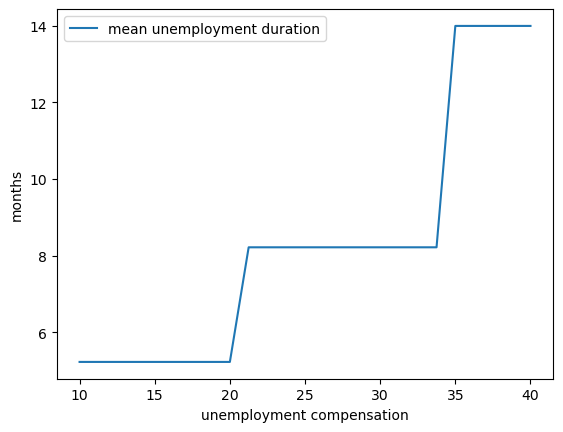

In [15]:
# Convert JAX arrays to NumPy arrays for use with Numba
q_default_np = np.array(q_default)
w_default_np = np.array(w_default)
cdf = np.cumsum(q_default_np)

@numba.jit
def compute_stopping_time(w_bar, seed=1234):
    """
    Compute stopping time by drawing wages until one exceeds w_bar.
    """
    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default_np[qe.random.draw(cdf)]

        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@numba.jit(parallel=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    """
    Generate a mean stopping time over `num_reps` repetitions by
    drawing from `compute_stopping_time`.
    """
    obs = np.empty(num_reps)
    for i in numba.prange(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage_two(mcm)
    stop_times[i] = compute_mean_stopping_time(float(w_bar))

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()



And here's a solution using JAX.

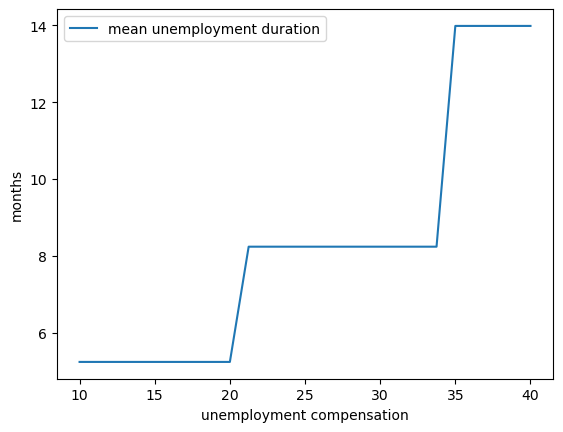

In [16]:
cdf = jnp.cumsum(q_default)

def compute_stopping_time(w_bar, key):
    """
    Compute stopping time by drawing wages until one exceeds `w_bar`.
    """
    def update(loop_state):
        t, key, accept = loop_state
        key, subkey = jax.random.split(key)
        u = jax.random.uniform(subkey)
        w = w_default[jnp.searchsorted(cdf, u)]
        accept = w >= w_bar
        t = t + 1
        return t, key, accept

    def cond(loop_state):
        _, _, accept = loop_state
        return jnp.logical_not(accept)

    initial_loop_state = (0, key, False)
    t_final, _, _ = jax.lax.while_loop(cond, update, initial_loop_state)
    return t_final


def compute_mean_stopping_time(w_bar, num_reps=100000, seed=1234):
    """
    Generate a mean stopping time over `num_reps` repetitions by
    drawing from `compute_stopping_time`.
    """
    # Generate a key for each MC replication
    key = jax.random.PRNGKey(seed)
    keys = jax.random.split(key, num_reps)

    # Vectorize compute_stopping_time and evaluate across keys
    compute_fn = jax.vmap(compute_stopping_time, in_axes=(None, 0))
    obs = compute_fn(w_bar, keys)

    # Return mean stopping time
    return jnp.mean(obs)

c_vals = jnp.linspace(10, 40, 25)

@jax.jit
def compute_stop_time_for_c(c):
    """Compute mean stopping time for a given compensation value c."""
    model = McCallModel(c=c)
    w_bar = compute_reservation_wage_two(model)
    return compute_mean_stopping_time(w_bar)

# Vectorize across all c values
stop_times = jax.vmap(compute_stop_time_for_c)(c_vals)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

At least for our hardware, Numba is faster on the CPU while JAX is faster on the GPU.

## Exercise

The purpose of this exercise is to show how to replace the discrete wage
offer distribution used above with a continuous distribution.

This is a significant topic because many convenient distributions are
continuous (i.e., have a density).

Fortunately, the theory changes little in our simple model.

Recall that $h$ in equation (j1) denotes the value of not accepting a job in this period but
then behaving optimally in all subsequent periods:

To shift to a continuous offer distribution, we can replace equation (j1) by

$$
h
= c + \beta
    \int v^*(s') q (s') ds'.
\quad
$$

Equation (j2) becomes

$$
h
= c + \beta
    \int
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s') d s'
\quad
$$

The aim is to solve this nonlinear equation by iteration, and from it obtain
the reservation wage.

Try to carry this out, setting

* the state sequence $\{ s_t \}$ to be IID and standard normal and
* the wage function to be $w(s) = \exp(\mu + \sigma s)$.

You will need to implement a new version of the `McCallModel` class that
assumes a lognormal wage distribution.

Calculate the integral by Monte Carlo, by averaging over a large number of wage draws.

For default parameters, use `c=25, β=0.99, σ=0.5, μ=2.5`.

Once your code is working, investigate how the reservation wage changes with $c$ and $\beta$.

## Solution

Here is one solution:

In [17]:
class McCallModelContinuous(NamedTuple):
    c: float              # unemployment compensation
    β: float              # discount factor
    σ: float              # scale parameter in lognormal distribution
    μ: float              # location parameter in lognormal distribution
    w_draws: jnp.ndarray  # draws of wages for Monte Carlo


def create_mccall_continuous(
        c=25, β=0.99, σ=0.5, μ=2.5, mc_size=1000, seed=1234
    ):
    key = jax.random.PRNGKey(seed)
    s = jax.random.normal(key, (mc_size,))
    w_draws = jnp.exp(μ + σ * s)
    return McCallModelContinuous(c=c, β=β, σ=σ, μ=μ, w_draws=w_draws)


@jax.jit
def compute_reservation_wage_continuous(model, max_iter=500, tol=1e-5):
    c, β, σ, μ, w_draws = model.c, model.β, model.σ, model.μ, model.w_draws
    
    h = jnp.mean(w_draws) / (1 - β)  # initial guess
    
    def update(state):
        h, i, error = state
        integral = jnp.mean(jnp.maximum(w_draws / (1 - β), h))
        h_next = c + β * integral
        error = jnp.abs(h_next - h)
        return h_next, i + 1, error
    
    def cond(state):
        h, i, error = state
        return jnp.logical_and(i < max_iter, error > tol)
    
    initial_state = (h, 0, tol + 1)
    h_final, _, _ = jax.lax.while_loop(cond, update, initial_state)
    
    # Now compute the reservation wage
    return (1 - β) * h_final

Now we investigate how the reservation wage changes with $c$ and
$\beta$.

We will do this using a contour plot.

In [18]:
grid_size = 25
c_vals = jnp.linspace(10.0, 30.0, grid_size)
β_vals = jnp.linspace(0.9, 0.99, grid_size)

def compute_R_element(c, β):
    model = create_mccall_continuous(c=c, β=β)
    return compute_reservation_wage_continuous(model)

# Create meshgrid and vectorize computation
c_grid, β_grid = jnp.meshgrid(c_vals, β_vals, indexing='ij')
compute_R_vectorized = jax.vmap(
    jax.vmap(compute_R_element, 
    in_axes=(None, 0)), 
    in_axes=(0, None))
R = compute_R_vectorized(c_vals, β_vals)

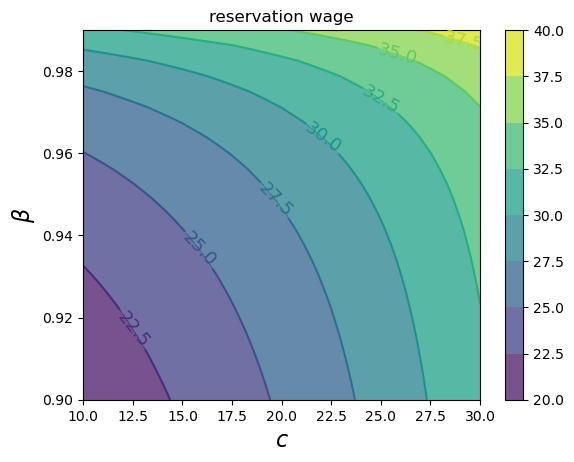

In [19]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()